Each models is required to generate a stack ranking of all properties listed for sale in the database.

This script runs daily, reads in CSV files with a sorted order of homes (most attractive at the top to least attractive at the bottom), and a 'ypred' variable that reflects the scripts absolute metric (like P&L or probability of sale).

The script compares each list with homes that were sold, and identifies closed transactions ('positives') as well as the top 10 properties that each model identified that didn't sell ('negatives'). The remainder is considered 'control set'. 

For the overall data set, and specifically for each of those 3 groups, we output the average 'ypred' value, what number and percentage of homes sold from each.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from slacker import Slacker
import json
import requests
from cloudinary.uploader import upload
from cloudinary.utils import cloudinary_url
from cloudinary.api import delete_resources_by_tag, resources_by_tag

csv_path = '/home/ilya/Code/rentalnerd/scraper/'
today = dt.date.today()


%matplotlib inline
        
# slack secrets (in your ~/.bashrc)
webhook_url = os.environ.get('SLACK_URL')
slacker = Slacker(os.environ.get('SLACK_TOKEN'))

# how old a target list to compare to the current target list
lag_days = 40

pd.set_option('display.max_colwidth', -1)
discount = 0.050

# to remove all the random far away areas - PHX only
zipcode_list = ['85006', '85007', '85008', '85009', '85013', '85015', '85016', '85017',
       '85018', '85019', '85020', '85021', '85022', '85023', '85024',
       '85027', '85028', '85029', '85031', '85033', '85035', '85037',
       '85040', '85041', '85043', '85044', '85048', '85050', '85051',
       '85053', '85085', '85086', '85087', '85118', '85138', '85139',
       '85142', '85143', '85202', '85203', '85204', '85205', '85206',
       '85207', '85209', '85210', '85212', '85213', '85215', '85224',
       '85225', '85226', '85233', '85234', '85248', '85249', '85250',
       '85251', '85253', '85254', '85255', '85257', '85258', '85262',
       '85266', '85286', '85295', '85296', '85297', '85298', '85301',
       '85302', '85303', '85304', '85305', '85306', '85308', '85310',
       '85323', '85326', '85331', '85335', '85339', '85340', '85351',
       '85353', '85355', '85373', '85374', '85375', '85382', '85383',
       '85388', '85390', '85392', '85396', '85704', '85705', '85706',
       '85711', '85712']

In [2]:
def plot_rounds(plot):
    # uploads the graph to the web and returns the URL
    
    fig = plot.get_figure()
    fig.tight_layout()
    fig.savefig('temp_plot.png')
    
    response = upload("temp_plot.png")
    url, options = cloudinary_url(response['public_id'],
        format = response['format'],
        crop = "fill")
    return url

In [3]:
def slack(text, url = None, title = None):
    print("Slacking: " + text)
    
    if url == None:
        data=json.dumps({"text": text})
    else:
        data = json.dumps( { "text": text, "attachments": [ { "fallback": "Model MAE"
                                           , "title": title
                                           , "image_url": url } ] } )
    
    response = requests.post(webhook_url, data , headers={'Content-Type': 'application/json'})
    if response.status_code != 200:
        raise ValueError('Request to slack returned an error %s, the response is:\n%s' % (response.status_code, response.text))


In [4]:
closed = pd.read_csv('CSV_backups/ALL-sales.csv',nrows=10000000, index_col=['property_id','transaction_id'])

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,14,15,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
closed.head()

price transaction_status date_listed  \
property_id transaction_id                                          
9023209     23824994        289000  closed             NaN          
9023224     23824986        163900  closed             NaN          
8993170     23824959        335000  closed             NaN          
328509      23824912        170000  closed             NaN          
            23824911        94000   closed             NaN          

                            date_closed  days_on_market transaction_type  \
property_id transaction_id                                                 
9023209     23824994        4336        NaN              sales             
9023224     23824986       -2957        NaN              sales             
8993170     23824959        6465        NaN              sales             
328509      23824912        6408        NaN              sales             
            23824911       -387         NaN              sales             

                            is_latest  price_listed  price_closed  \
property_id transaction_id                                          
9023209     23824994        False     NaN            289000         
9023224     23824986        False     NaN            163900         
8993170     23824959        False      325000.0      335000         
328509      23824912        False     NaN            170000         
            23824911        False     NaN            94000          

                           date_transacted_latest          ...            \
property_id transaction_id                                 ...             
9023209     23824994        2011-11-15                     ...             
9023224     23824986        1991-11-27                     ...             
8993170     23824959        2017-09-13                     ...             
328509      23824912        2017-07-18                     ...             
            23824911        1998-12-10                     ...             

                            school_district_id_57.0  school_district_id_60.0  \
property_id transaction_id                                                     
9023209     23824994        0                        0                         
9023224     23824986        0                        0                         
8993170     23824959        0                        0                         
328509      23824912        0                        0                         
            23824911        0                        0                         

                           school_district_id_67.0 school_district_id_68.0  \
property_id transaction_id                                                   
9023209     23824994        0                       0                        
9023224     23824986        0                       0                        
8993170     23824959        0                       0                        
328509      23824912        0                       1                        
            23824911        0                       1                        

                           school_district_id_75.0  school_district_id_87.0  \
property_id transaction_id                                                    
9023209     23824994        0                       0                         
9023224     23824986        0                       0                         
8993170     23824959        0                       0                         
328509      23824912        0                       0                         
            23824911        0                       0                         

                           school_district_id_90.0 school_district_id_93.0  \
property_id transaction_id                                                   
9023209     23824994        0                       0                        
9023224     23824986        0                       0                        
8993170     23824959 

In [6]:
# read in prior target list for backtesting purposes
model_results = np.empty([0,7])
for lag_days in range(1,2):
    print("Lag days %i\n\n" % lag_days)
    try:
        prior_target_list = pd.read_csv(csv_path + 'good_sell/gs_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                    .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                    .rename(columns = { 'ypred' : 'good_sell_prob'})

        backtest = prior_target_list.join(closed[['price']], how="inner").sort_values(by='good_sell_prob',ascending=False)
        backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
        y_all = prior_target_list.good_sell_prob.mean()
        y_sold = backtest.good_sell_prob.mean()

        pos_trigger = prior_target_list.good_sell_prob.quantile(0.75)
        slack("Prior target list length: %i\tNum sold: %i\tAvg good sell prob: %f\tAvg good sell prob of sold: %f" 
              % (len(prior_target_list.index), len(backtest.index),y_all, y_sold))

        num_pos = len(prior_target_list[prior_target_list.good_sell_prob > pos_trigger].index)
        positives = backtest[backtest.good_sell_prob > pos_trigger]
        y_pos = (-(positives.price - positives.list) / positives.list).median()
        num_sold = len(positives.index)
        if num_sold == 0:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: NONE\tMed disc to list: NA" % (pos_trigger, num_pos) )    
        else:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: %f\tMed disc to list: %f" 
                  % (pos_trigger, num_pos, num_sold / num_pos *  100, y_pos * 100))

        neg_trigger = prior_target_list.good_sell_prob.quantile(0.25)
        num_neg = len(prior_target_list[prior_target_list.good_sell_prob < neg_trigger].index)
        negatives = backtest[backtest.good_sell_prob < neg_trigger]
        y_neg = (-(negatives.price - negatives.list) / negatives.list).median()
        num_sold = len(negatives.index)

        if num_sold == 0:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: NONE\tMedian disc to list: NA" % (neg_trigger, num_neg))
        else:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: %f\tMedian disc to list:%f" 
                  % (neg_trigger, num_neg, len(negatives.index) / num_neg * 100, y_neg * 100))

        slack(backtest.to_string())
        backtest.to_csv("median_check.csv")
        # store results in arrays for graphing
        r = np.array([[lag_days, len(prior_target_list.index), len(backtest.index), num_sold / num_pos * 100, y_pos * 100, len(negatives.index) / num_neg * 100, y_neg * 100]])
        model_results = np.append(model_results,r,axis=0)
        
    except Exception as err:   
        print(err)

Lag days 1


Slacking: Prior target list length: 1522	Num sold: 0	Avg good sell prob: 0.497902	Avg good sell prob of sold: nan
Slacking: Num of homes with good_sell_prob > 0.619874: 381	Perc of those sold: NONE	Med disc to list: NA
Slacking: Num of homes with good_sell_prob < 0.409466: 381	Perc of those sold: NONE	Median disc to list: NA
Slacking: Empty DataFrame
Columns: [address, zipcode, good_sell_prob, list, url, lat, long, date_listed, transaction_date, price, good_sell]
Index: []


In [7]:
import matplotlib.pyplot as plt
index = pd.Index(model_results[:,0], names='lag_days')
graph_results = pd.DataFrame(model_results[:,1:],index=index,columns=['num_for_sale', 'num_sold', 'perc_sold_good','discount_good', 'perc_sold_bad', 'discount_bad']) \
                    .sort_index(ascending=False)

graph_results.head()

,num_for_sale,num_sold,perc_sold_good,discount_good,perc_sold_bad,discount_bad
1.0,1522.0,0.0,0.0,NaN,0.0,NaN


In [8]:
# graph_results[['num_for_sale', 'discount_good','discount_bad']].plot(figsize=(14,14),secondary_y='num_for_sale')

In [9]:
# read in prior target list for backtesting purposes
prior_target_list = pd.read_csv(csv_path + 'value_buy/vb_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                .rename(columns = { 'ypred' : 'pnl'})

try:
    backtest = prior_target_list.join(closed['price'], how="inner").sort_values(by='pnl',ascending=False)
    backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
    avg_pnl = backtest.pnl.mean()
    predicted_price = backtest.predicted_price.mean()
    sale_price = backtest.price.mean()

    slack("Prior target list length: %i\tNum sold: %i\tAvg P&L: %f\tAvg predict price: %f\tAvg sale price: %f" 
          % (len(prior_target_list.index), len(backtest.index),y_all, predicted_price, sale_price))

    pos_trigger = prior_target_list.pnl.quantile(0.75)
    num_pos = len(prior_target_list[prior_target_list.pnl > pos_trigger].index)
    positives = backtest[backtest.pnl > pos_trigger]
    y_pos = (-(positives.price - positives.list) / positives.list).mean()
    num_sold = len(positives.index)
    if num_sold == 0:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (pos_trigger, num_pos) )    
    else:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: %f\tAvg disc to list: %f" 
              % (pos_trigger, num_pos, num_sold / num_pos, y_pos))

    neg_trigger = prior_target_list.pnl.quantile(0.25)

    num_neg = len(prior_target_list[prior_target_list.pnl < neg_trigger].index)
    negatives = backtest[backtest.pnl < neg_trigger]
    y_neg = (-(negatives.price - negatives.list) / negatives.list).mean()
    num_sold = len(negatives.index)

    if num_sold == 0:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (neg_trigger, num_neg))
    else:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: %f\tAvg disc to list:%f" 
              % (neg_trigger, num_neg, len(negatives.index) / num_neg, y_neg))

    slack(backtest.to_string())
except Exception as err:   
    slack("No homes sold since last run")

Slacking: Prior target list length: 2762	Num sold: 0	Avg P&L: 0.497902	Avg predict price: nan	Avg sale price: nan
Slacking: Num of homes with pnl > -102538.179688: 691	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Num of homes with pnl < -186749.281250: 691	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Empty DataFrame
Columns: [address, zipcode, pnl, predicted_price, list, url, price, good_sell]
Index: []


In [10]:
vb = pd.read_csv('value_buy/vb_target_list_' + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id']) \
       .drop(['address','zipcode', 'url','list'],axis=1) \
       .rename(columns = { 'ypred': 'pnl'}) \
       .drop_duplicates()
    
gs = pd.read_csv('good_sell/gs_target_list_'  + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id'])  \
       .rename(columns = { 'ypred' : 'good_sell_prob'}) \
       .drop_duplicates()
        
vb = vb[~vb.index.duplicated(keep='first')]
gs = gs[~gs.index.duplicated(keep='first')]
    
print("Len of value buy\t%i" % len(vb.index))
print("Len of good sell\t%i" % len(gs.index))

c = pd.concat([vb,gs],axis=1, join='inner')

c['pnl_percent'] = (c.pnl / c.list)

c = c[(c.list < 250000) & (c.list > 100000)  \
      & (~c.address.str.contains("Rent|rent|LOT|#|Sun City"))] 

Len of value buy	2761
Len of good sell	1522


/home/ilya/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Slacking: 


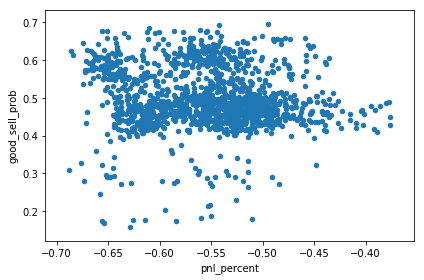

In [11]:
url = plot_rounds(c.query('good_sell_prob > 0.00').plot.scatter(x='pnl_percent', y='good_sell_prob'))
slack("", url, "Model Correlation")

In [12]:
# ran both data datasets and combine to create an equally weighted ensemble ranking
c["pnl_rank"] = c.pnl.rank(ascending=False)
c["gs_rank"] = c.good_sell_prob.rank(ascending=False)
c["rank"] = (c.pnl_rank + c.gs_rank)
c["zipcode"] = c.zipcode.apply(str)

# filter the output to remove duds
d = c[(c.pnl_percent > -0.2) & (c.good_sell_prob > 0.4) & (c.zipcode.isin(zipcode_list))]

In [13]:
d = c.sort_values("rank").nsmallest(20, "gs_rank")

file = csv_path + 'ensemble/comb_target_list_' + today.strftime('%Y%m%d') + '.csv'
np.round(d[['address', 'zipcode','list','predicted_price','pnl_percent','good_sell_prob','rank','url']], 4).to_csv(file)

slacker.files.upload(file, channels='#progress')

In [14]:
for_sale = pd.read_csv('CSV_backups/ALL-for_sale.csv', index_col=['property_id','transaction_id'])
for_sale['zipcode'] = for_sale.zipcode.apply(str)

In [15]:
from math import radians, cos, sin, asin, sqrt
def haversine(row, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = row.longitude
    lat1 = row.latitude
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km / 1.60934 # convert to miles

In [16]:
for r, target in d.iterrows():
    print(target.name[0])
    print(target.address)
    target.longitude = for_sale.loc[target.name].longitude
    target.latitude = for_sale.loc[target.name].latitude
    
    # get all properties listed for sale in the same zipcode as our target
    z = for_sale[(for_sale.zipcode == target.zipcode)]
    print(len(z.longitude))
    
    z['dist'] = z.apply(haversine, lon2 = target.longitude, lat2 = target.latitude, axis=1)
    print(z[['address','dist']].nsmallest(5,'dist'))
    

360355
8331 W Pima St, Tolleson, AZ 85353 
21
                                                           address      dist
property_id transaction_id                                                  
360355      22733584        8331 W Pima St, Tolleson, AZ 85353      0.000000
360201      22563730        8302 W Mohave St, Tolleson, AZ 85353    0.100928
9020793     23819086        8425 W Cocopah St, Tolleson, AZ 85353   0.112542
359261      23797163        2001 S 83rd Dr, Tolleson, AZ 85353      0.275392
359302      23814410        2021 S 83rd Dr, Tolleson, AZ 85353      0.322816
9016802
11602 N 67th Dr, Peoria, AZ 85345 
99
                                                              address  \
property_id transaction_id                                              
9016802     22737152        11602 N 67th Dr, Peoria, AZ 85345           
9022548     23818007        6803 W Cherry Hills Dr, Peoria, AZ 85345    
7449241     23819586        11935 N 68th Ave, Peoria, AZ 85345          
8988

/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                                              address  \
property_id transaction_id                                              
414806      22647037        6601 W Poinsettia Dr, Glendale, AZ 85304    
414937      23823742        6625 W Poinsettia Dr, Glendale, AZ 85304    
414496      23817507        6419 W Yucca St, Glendale, AZ 85304         
401514      23796911        11223 N 63rd Dr, Glendale, AZ 85304         
413798      23811011        6136 W Sierra St, Glendale, AZ 85304        

                                dist  
property_id transaction_id            
414806      22647037        0.000000  
414937      23823742        0.061134  
414496      23817507        0.455182  
401514      23796911        0.493057  
413798      23811011        0.535770  
382253
12607 N 38th Ln, Phoenix, AZ 85029 
94
                                                             address      dist
property_id transaction_id                                                    
382253     

In [17]:
d

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,date_listed,transaction_date,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,,,
360355,22733584,-101339.000000,103661.000000,"8331 W Pima St, Tolleson, AZ 85353",85353,0.695048,205000,https://www.zillow.com/homedetails/8331-W-Pima-St-Tolleson-AZ-85353/58770098_zpid/,33.4334,-112.240,2017-10-02,2017-10-02,-0.494337,327.0,1.0,328.0
9016802,22737152,-111174.476562,93824.523438,"11602 N 67th Dr, Peoria, AZ 85345",85345,0.692084,204999,https://www.zillow.com/homedetails/11602-N-67th-Dr-Peoria-AZ-85345/7699701_zpid/,33.5907,-112.203,2017-10-04,2017-10-04,-0.542317,701.0,2.0,703.0
975705,23809139,-152540.382812,97359.617188,"704 N Country Club Way, Chandler, AZ 85226",85226,0.683880,249900,https://www.zillow.com/homedetails/704-N-Country-Club-Way-Chandler-AZ-85226/8155320_zpid/,33.3150,-111.904,2017-10-13,2017-10-13,-0.610406,1372.0,3.0,1375.0
414806,22647037,-109295.773438,85704.226562,"6601 W Poinsettia Dr, Glendale, AZ 85304",85304,0.680875,195000,https://www.zillow.com/homedetails/6601-W-Poinsettia-Dr-Glendale-AZ-85304/7699545_zpid/,33.5934,-112.201,2017-09-09,2017-09-09,-0.560491,623.0,4.0,627.0
382253,22737157,-110315.906250,88684.093750,"12607 N 38th Ln, Phoenix, AZ 85029",85029,0.677086,199000,https://www.zillow.com/homedetails/12607-N-38th-Ln-Phoenix-AZ-85029/7743224_zpid/,33.5997,-112.142,2017-09-25,2017-09-25,-0.554351,663.0,5.0,668.0
9015638,22704145,-116103.597656,60796.402344,"8444 W Lewis Ave, Phoenix, AZ 85037",85037,0.676793,176900,https://www.zillow.com/homedetails/8444-W-Lewis-Ave-Phoenix-AZ-85037/82823102_zpid/,33.4743,-112.241,2017-09-21,2017-09-21,-0.656323,882.0,6.0,888.0
8973255,23753390,-114449.183594,61450.816406,"7811 W Palm Ln, Phoenix, AZ 85035",85035,0.676739,175900,https://www.zillow.com/homedetails/7811-W-Palm-Ln-Phoenix-AZ-85035/95151582_zpid/,33.4685,-112.228,2017-10-13,2017-10-13,-0.650649,825.0,7.0,832.0
422815,22722094,-126095.882812,88904.117188,"8324 N 56th Ln, Glendale, AZ 85302",85302,0.676618,215000,https://www.zillow.com/homedetails/8324-N-56th-Ln-Glendale-AZ-85302/7732897_zpid/,33.5576,-112.181,2017-09-26,2017-09-26,-0.586492,1126.0,8.0,1134.0
526828,22737450,-119092.070312,95407.929688,"9418 W Sheridan St, Phoenix, AZ 85037",85037,0.674593,214500,https://www.zillow.com/homedetails/9418-W-Sheridan-St-Phoenix-AZ-85037/67773035_zpid/,33.4750,-112.262,2017-09-28,2017-09-28,-0.555208,987.0,9.0,996.0


In [18]:
d.head()

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,date_listed,transaction_date,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,,,
360355,22733584,-101339.000000,103661.000000,"8331 W Pima St, Tolleson, AZ 85353",85353,0.695048,205000,https://www.zillow.com/homedetails/8331-W-Pima-St-Tolleson-AZ-85353/58770098_zpid/,33.4334,-112.240,2017-10-02,2017-10-02,-0.494337,327.0,1.0,328.0
9016802,22737152,-111174.476562,93824.523438,"11602 N 67th Dr, Peoria, AZ 85345",85345,0.692084,204999,https://www.zillow.com/homedetails/11602-N-67th-Dr-Peoria-AZ-85345/7699701_zpid/,33.5907,-112.203,2017-10-04,2017-10-04,-0.542317,701.0,2.0,703.0
975705,23809139,-152540.382812,97359.617188,"704 N Country Club Way, Chandler, AZ 85226",85226,0.683880,249900,https://www.zillow.com/homedetails/704-N-Country-Club-Way-Chandler-AZ-85226/8155320_zpid/,33.3150,-111.904,2017-10-13,2017-10-13,-0.610406,1372.0,3.0,1375.0
414806,22647037,-109295.773438,85704.226562,"6601 W Poinsettia Dr, Glendale, AZ 85304",85304,0.680875,195000,https://www.zillow.com/homedetails/6601-W-Poinsettia-Dr-Glendale-AZ-85304/7699545_zpid/,33.5934,-112.201,2017-09-09,2017-09-09,-0.560491,623.0,4.0,627.0
382253,22737157,-110315.906250,88684.093750,"12607 N 38th Ln, Phoenix, AZ 85029",85029,0.677086,199000,https://www.zillow.com/homedetails/12607-N-38th-Ln-Phoenix-AZ-85029/7743224_zpid/,33.5997,-112.142,2017-09-25,2017-09-25,-0.554351,663.0,5.0,668.0
